In [95]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from keras.models import Model
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D
from keras.layers import  BatchNormalization, LeakyReLU, Dropout, Activation

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import LearningRateScheduler

# Load csv from Desktop

In [113]:
NUM_CLASSES = 2
CLASSES = np.array(['Legitimate', 'Suspicious'])
DATASET_DIR = "dataset/"
VECTOR_LENGTH = 1 * 816

def csvToVector(file_path):
    data = pd.read_csv(file_path, header=None)
    vector = data.values.flatten()
    return vector

def load_data(dataset_dir):
    X = []
    y = []
    subdirs = ['0', '1']

    for class_idx, class_name in enumerate(subdirs):
        class_dir = os.path.join(dataset_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_dir, file_name)
                vector = csvToVector(file_path)
                X.append(vector)
                y.append(class_idx)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [114]:
X, y = load_data(DATASET_DIR)

In [115]:
print(X.shape)
print(y.shape)
print(X)
print(y)

(8, 816)
(8,)
[[6350    0    0 ...   29    0   48]
 [6350    0    0 ...   29    0   48]
 [6350    0    0 ...   29    0   48]
 ...
 [6350    0    0 ...   29    0   48]
 [6350    0    0 ...   29    0   48]
 [6350    0    0 ...   29    0   48]]
[0 0 0 0 1 1 1 1]


# Train, Validation, Test Split and Nomalize

In [99]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [100]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4, 816)
(3, 816)
(1, 816)
(4, 2)
(3, 2)
(1, 2)


# 1D CNN Architecture

In [101]:
input_layer = Input(shape=(VECTOR_LENGTH, 1))

x = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=64, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Flatten()(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [102]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 816, 1)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 816, 32)           128       
                                                                 
 batch_normalization_8 (Batc  (None, 816, 32)          128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 816, 32)           0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 408, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 408, 64)           6208

# CheckPoint

In [103]:
cp = ModelCheckpoint(
    filepath='cp/CMS_CNN_1D_CheckPoint.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Learning Rate

In [104]:
def print_lr(epoch, lr):
    print(f"Learning rate for epoch {epoch} is {lr}")
    return lr

lr = LearningRateScheduler(print_lr)

# Model Training

In [105]:
model.fit(X_train, 
          y_train,
          validation_data=(X_val, y_val),
          batch_size=32, 
          epochs=100, 
          shuffle=True,
          callbacks=[lr, cp]
)

Learning rate for epoch 0 is 0.0010000000474974513
Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.2500
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to cp/CMS_CNN_1D_CheckPoint.h5
1/1 [==============================] - 2s 2s/step - loss: 0.6931 - accuracy: 0.2500 - val_loss: 0.6992 - val_accuracy: 0.0000e+00 - lr: 0.0010
Learning rate for epoch 1 is 0.0010000000474974513
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7500
Epoch 2: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 146ms/step - loss: 0.6907 - accuracy: 0.7500 - val_loss: 0.7045 - val_accuracy: 0.0000e+00 - lr: 0.0010
Learning rate for epoch 2 is 0.0010000000474974513
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.7500
Epoch 3: val_accuracy did not improve from 0.00000
1/1 [==============================] - 0s 68ms/step - loss: 0.6871 - accuracy: 0

# Load Best CheckPoint

In [106]:
cp_model = load_model('cp/CMS_CNN_1D_CHeckPoint.h5')
cp_model.evaluate(X_test, y_test, batch_size=1000)

1/1 [==============================] - 0s 346ms/step - loss: 0.6952 - accuracy: 0.3333


[0.6951704025268555, 0.3333333432674408]

# Evaluate

In [107]:
y_pred = cp_model.predict(X_test)

1/1 [==============================] - 0s 232ms/step


In [108]:
preds_single = CLASSES[np.argmax(y_pred, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

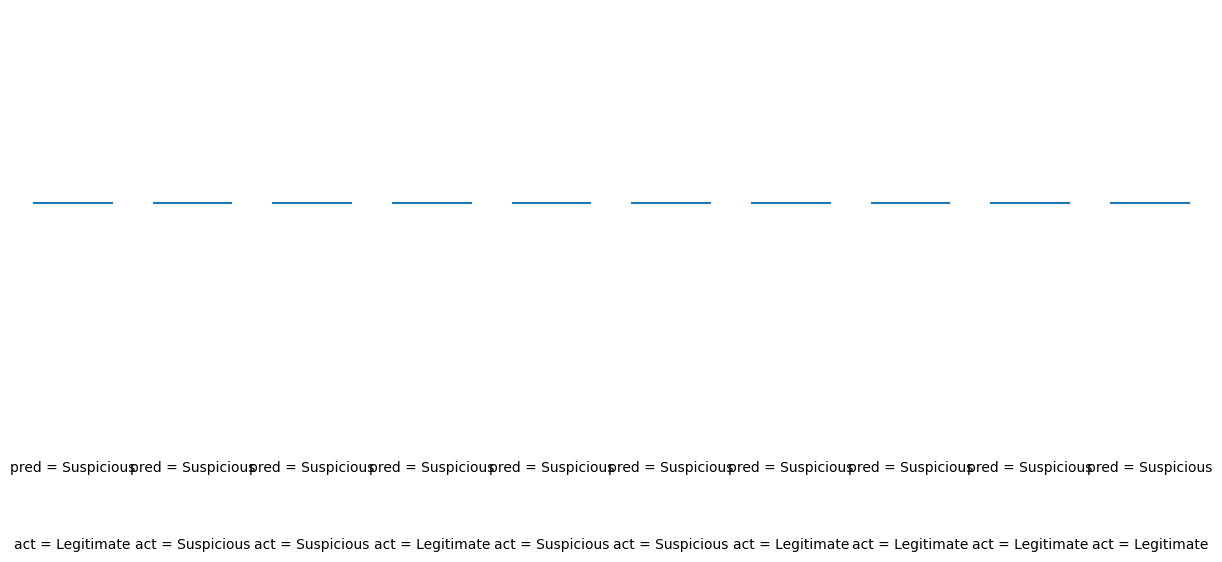

In [109]:
n_to_show = 10
indices = np.random.choice(range(len(X_test)), n_to_show)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    data = X_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.plot(data)
    ax.axis('off')
    ax.text(0.5, -0.2, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.4, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)

plt.show()

# Classification Results

In [110]:
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gyeonghoon_park/miniforge3/envs/TF/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# Confusion MatriX

In [111]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

class_labels = ['Legitimate', 'Suspicious']

conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
            Legitimate  Suspicious
Legitimate           0           2
Suspicious           0           1


# ROC Curve

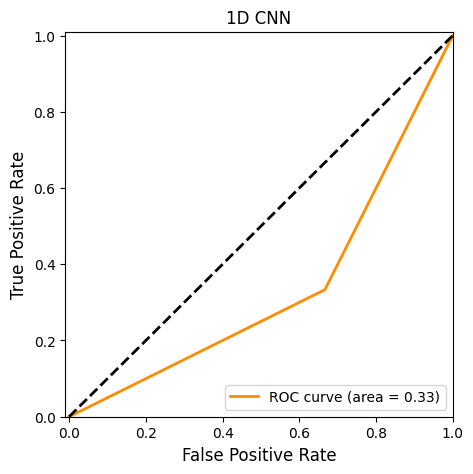

In [112]:
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.rcParams['font.size'] = 10
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('1D CNN')
plt.legend(loc="lower right")
#plt.savefig('ROC_Curve_cms_1d_cnn.pdf', dpi=1000)
plt.show()